# How to search the IOOS CSW catalog with Python tools


This notebook demonstrates a how to query a [Catalog Service for the Web (CSW)](https://en.wikipedia.org/wiki/Catalog_Service_for_the_Web), like the IOOS Catalog, and to parse its results into endpoints that can be used to access the data.

In [1]:
import os
import sys

ioos_tools = os.path.join(os.path.pardir)
sys.path.append(ioos_tools)

Let's start by creating the search filters.
The filter used here constraints the search on a certain geographical region (bounding box), a time span (last week), and some [CF](http://cfconventions.org/Data/cf-standard-names/37/build/cf-standard-name-table.html) variable standard names that represent sea surface temperature.

In [2]:
from datetime import datetime, timedelta

# Region: Northwest coast.
bbox = [-127, 43, -123.75, 48]
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Temporal range: Last week.
now = datetime.utcnow()
start, stop = now - timedelta(days=(7)), now

# Sea surface temperature CF names.
cf_names = ['sea_water_temperature',
            'sea_surface_temperature',
            'sea_water_potential_temperature',
            'equivalent_potential_temperature',
            'sea_water_conservative_temperature',
            'pseudo_equivalent_potential_temperature']

With these 3 elements it is possible to assemble a [OGC Filter Encoding (FE)](http://www.opengeospatial.org/standards/filter) using the `owslib.fes`\* module.

\* OWSLib is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models.

In [3]:
from owslib import fes
from ioos_tools.ioos import fes_date_filter

kw = dict(wildCard='*', escapeChar='\\',
          singleChar='?', propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And(
        [
            bbox_crs,  # bounding box
            begin, end,  # start and end date
            or_filt  # or conditions (CF variable names)
        ]
    )
]

In [4]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

The `csw` object created from `CatalogueServiceWeb` did not fetched anything yet.
It is the method `getrecords2` that uses the filter for the search. However, even though there is a `maxrecords` option, the search is always limited by the server side and there is the need to iterate over multiple calls of `getrecords2` to actually retrieve all records.
The `get_csw_records` does exactly that.

In [5]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty
    # Iterate over sorted results.
    sortby = SortBy([SortProperty('dc:title', 'ASC')])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, 'results', 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results['nextrecord'] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [6]:
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]\n{}\n'.format(value.title, key))

Found 39 records.

[SREF CONUS 40km Ensemble Derived Products (Bias Corrected)/Best SREF CONUS 40km Ensemble Derived Products (Bias Corrected) Time Series]
edu.ucar.unidata:grib/NCEP/SREF/CONUS_40km/ensprod_biasc/Best

[UCSC California Current System ROMS Nowcast 10km]
UCSC

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780

[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380

[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540

[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040

[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910

[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 

That search returned a lot of records!
What if the user is not interested in those model results nor global dataset?
We can those be excluded  from the search with a `fes.Not` filter.

In [7]:
kw = dict(
    wildCard='*',
    escapeChar='\\\\',
    singleChar='?',
    propertyname='apiso:AnyText')


filter_list = [
    fes.And(
        [
            bbox_crs,  # Bounding box
            begin, end,  # start and end date
            or_filt,  # or conditions (CF variable names).
            fes.Not([fes.PropertyIsLike(literal='*NAM*', **kw)]),  # no NAM results
            fes.Not([fes.PropertyIsLike(literal='*CONUS*', **kw)]),  # no NAM results
            fes.Not([fes.PropertyIsLike(literal='*GLOBAL*', **kw)]),  # no NAM results
            fes.Not([fes.PropertyIsLike(literal='*ROMS*', **kw)]),  # no NAM results
        ]
    )
]

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]\n{}\n'.format(value.title, key))

Found 12 records.

[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102

[urn:ioos:station:NOAA.NOS.CO-OPS:9442396 station, La Push, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9442396

[FNMOC COAMPS Northeast Pacific/Best FNMOC COAMPS Northeast Pacific Time Series]
edu.ucar.unidata:grib/FNMOC/COAMPS/Northeast_Pacific/Best

[COAMPS Ground and Sea Surface Temperature, 4km]
COAMPS_4KM_GRND_SEA_TEMP

[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380

[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780

[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
opendap.co-ops.nos.noa

12 Records. That's better. But if the user is interested in only some specific service, it is better to filter by a string, like [`CO-OPS`](https://tidesandcurrents.noaa.gov/).

In [8]:
filter_list = [
    fes.And(
        [
            bbox_crs,  # Bounding box
            begin, end,  # start and end date
            or_filt,  # or conditions (CF variable names).
            fes.PropertyIsLike(literal='*CO-OPS*', **kw),  # must have CO-OPS
        ]
    )
]

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]\n{}\n'.format(value.title, key))

Found 7 records.

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780

[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380

[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540

[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040

[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910

[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102

[urn:ioos:station:NOAA.NOS.CO-OPS:9442396 station, La Push, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9442396



The easiest way to get more information is to explorer the individual records.
Here is the `abstract` and `subjects` from the station in Astoria, OR.

In [9]:
import textwrap


value = csw.records['opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040']

print('\n'.join(textwrap.wrap(value.abstract)))

NOAA.NOS.CO-OPS Sensor Observation Service (SOS) Server  This station
provides the following variables: Air pressure, Air temperature, Sea
surface height amplitude due to equilibrium ocean tide, Sea water
temperature, Water surface height above reference datum, Wind from
direction, Wind speed, Wind speed of gust


In [10]:
print('\n'.join(value.subjects))

Air Temperature
Barometric Pressure
Conductivity
Currents
Datum
Harmonic Constituents
Rain Fall
Relative Humidity
Salinity
Visibility
Water Level
Water Level Predictions
Water Temperature
Winds
air_pressure
air_temperature
sea_surface_height_amplitude_due_to_equilibrium_ocean_tide
sea_water_temperature
water_surface_height_above_reference_datum
wind_from_direction
wind_speed
wind_speed_of_gust
climatologyMeteorologyAtmosphere


The next step is to inspect the type services/schemes available for downloading the data. The easiest way to accomplish that is with by "sniffing" the URLs with `geolinks`.

In [11]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: OGC:SOS
scheme: Astoria
URL: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?procedure=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&version=1.0.0&request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"&service=SOS

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&service=SOS&responseFormat=text/csv&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure&eventTime=2016-12-18T02:58:01/2016-12-18T04:58:01

geolink: OGC:SOS
scheme: WWW:LINK - text/xml
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&service=SOS&responseFormat=text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure&eventTime=2016-12-18T02:58:01/2016-12-18T04:58:01

geolink: OGC:SOS


There are many direct links to Comma Separated Value (`CSV`) and
eXtensible Markup Language (`XML`) responses to the various variables available in that station. 

In addition to those links, there are three very interesting links for more information: 1.) the QC document, 2.) the station photo, 3.) the station home page.


For a detailed description of what those `geolink` results mean check the [lookup](https://github.com/OSGeo/Cat-Interop/blob/master/LinkPropertyLookupTable.csv) table.


![](https://tidesandcurrents.noaa.gov/images/stationphotos/9439040A.jpg)

The original search was focused on sea water temperature,
so there is the need to extract only the endpoint for that variable.

PS: see also the [pyoos example](http://ioos.github.io/notebooks_demos/notebooks/2016-10-12-fetching_data/) for fetching data from `CO-OPS`.

In [12]:
start, stop

(datetime.datetime(2016, 12, 12, 20, 49, 29, 121653),
 datetime.datetime(2016, 12, 19, 20, 49, 29, 121653))

In [13]:
for ref in value.references:
    url = ref['url']
    if 'csv' in url and 'sea' in url and 'temperature' in url:
        print(msg(geolink=sniff_link(url), **ref))
        break

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&service=SOS&responseFormat=text/csv&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&eventTime=2016-12-18T02:58:01/2016-12-18T04:58:01



Note that the URL returned by the service has some hard-coded start/stop dates.
It is easy to overwrite those with the same dates from the filter.

In [14]:
fmt = ('http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
       'service=SOS&'
       'eventTime={0:%Y-%m-%dT00:00:00}/{1:%Y-%m-%dT00:00:00}&'
       'observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&'
       'version=1.0.0&'
       'request=GetObservation&offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&'
       'responseFormat=text/csv')

url = fmt.format(start, stop)

Finally, it is possible to download the data directly into a data `pandas` data frame and plot it.

In [15]:
import io
import requests
import pandas as pd

r = requests.get(url)

df = pd.read_csv(io.StringIO(r.content.decode('utf-8')),
                 index_col='date_time', parse_dates=True)

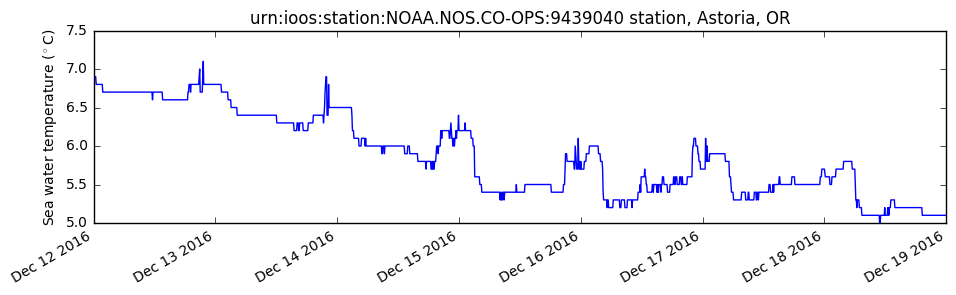

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(11, 2.75))
ax = df['sea_water_temperature (C)'].plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel(r'Sea water temperature ($^\circ$C)')
ax.set_title(value.title)